In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms 

%matplotlib inline 

# 1. Load the data

In [2]:
import csv
from torch.utils.data.dataset import Dataset 

def return_HM_npy(csvfile_path):
    Hs = []
    Ms = []
    with open(csvfile_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # Skipping the header
        for row in reader:
            Hs.append(float(row[0]))
            Ms.append(float(row[1]))
    return np.array(Hs), np.array(Ms)

def accept_test_middle(H, M, noise_std=0.01, f=None):
    noise = abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else:
        return False

def generate_training_data(noise_std=0.004, data_size=10000, Hrange=[0, 0.022], Mrange=[0, 0.11], f=None):
    H_pos_data = []
    M_pos_data = []
    F_pos_data = []
    #
    H_neg_data = []
    M_neg_data = []
    F_neg_data = []
    #
    while True:
        H = np.random.uniform(Hrange[0], Hrange[1])# sampling from uniform distribution.
        M = np.random.uniform(Mrange[0], Mrange[1]) 
        if accept_test_middle(H, M, noise_std, f) and len(F_pos_data)<data_size:
            H_pos_data.append([H])
            M_pos_data.append([M])
            F_pos_data.append([0])
        elif len(F_neg_data)<data_size:
            H_neg_data.append([H])
            M_neg_data.append([M])
            F_neg_data.append([1])
        if len(F_pos_data)==data_size and len(F_neg_data)==data_size:
            break
    return (np.array(H_pos_data), np.array(M_pos_data), np.array(F_pos_data)), (np.array(H_neg_data), np.array(M_neg_data), np.array(F_neg_data))

def plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f):
    plt.xlabel('quark mass [GeV]', fontsize=18)
    plt.ylabel(r'$\langle\bar{q}q\rangle$ [GeV$^3$]', fontsize=18)
    #
    plt.plot(positive_H_M_F[0], positive_H_M_F[1], 'b.', label='positive')
    plt.plot(negative_H_M_F[0], negative_H_M_F[1], 'g.', label='negative')
    hs = np.linspace(np.min(Hs), np.max(Hs), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(Hs, Ms, 'ro', label='data')
    plt.legend(loc='upper right',
               bbox_to_anchor=(1.05, 0.5, 0.5, .100), )
    plt.show()

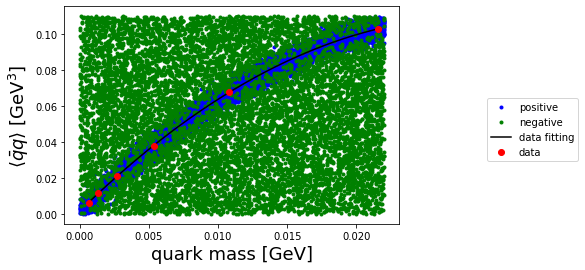

In [3]:
# data values
Hs, Ms = return_HM_npy('q-pp-highT-phys.csv') # data
# data fitting
f = np.poly1d(np.polyfit(Hs, Ms, deg=3)) # data fitting
# data augmentation (H_M_F = (x, y, 0/1) )
positive_H_M_F, negative_H_M_F = generate_training_data(data_size=10000, f=f)
# plot
plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [4]:
class Phi_Pi_DataSet(Dataset):
    ''' class for handling data '''
    def __init__(self, positive_H_M_F, negative_H_M_F, transform=None):
        self.phi = np.concatenate((positive_H_M_F[0], negative_H_M_F[0]),axis=0).astype(np.float32)
        self.Pi = np.concatenate((positive_H_M_F[1], negative_H_M_F[1]),axis=0).astype(np.float32)
        self.ans = np.concatenate((positive_H_M_F[2], negative_H_M_F[2]),axis=0).astype(np.float32)
        self.transform = transform

    def __getitem__(self, index):
        phi = self.phi[index]
        Pi = self.Pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi = self.transform(phi)
            Pi = self.transform(Pi)
            ans = self.transform(ans)
        return phi, Pi, ans

    def __len__(self):
        return len(self.phi)

In [5]:
train_d_loader = DataLoader(Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=100, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [7]:
import torch.nn as nn 
import torch.nn.functional as F

def onestep(phi, pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*pi
    pi1 = phi*m2*del_eta + (1-del_eta*hh)*pi + del_eta*lamb*(phi1**3)
    return phi1, pi1
def f(phi, pi):
    return pi
def t(a):
    return 0.5*(torch.tanh(100*(a-0.1))-torch.tanh(100*(a+0.1))+2)

class MetricNet(nn.Module):
    def __init__(self, N_layer=None, eta_ini=None, eta_fin=None, m2=None, 
                 del_eta=None, d=None):
        super(MetricNet, self).__init__()
        # trained parameters
        Hs = []
        for layer_index in range(N_layer):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs = nn.ModuleList(Hs)
        self.adsradius = nn.Linear(1, 1, bias=False)
        self.lamb = nn.Linear(1, 1, bias=False)
        # fixed parameters
        self.one = Variable(torch.ones(1)) # it would be better to use torch.nn.parameter.
        self.N_layer = N_layer
        self.eta_ini = eta_ini
        self.eta_fin = eta_fin
        self.m2 = m2
        self.del_eta = del_eta
        self.d = d
    def show_Hs(self):
        H=[]
        for i in range (N_layer):
            H.append(self.Hs[i](self.one).data.numpy()[0])
        return np.array(H)            
    def show_lamb(self):
        return self.lamb(self.one)
    def show_adsradius(self):
        return self.adsradius(self.one)
    
    def penalty(self):
        pen=0
        for i in range (self.N_layer-1):
            H1=self.Hs[i](self.one)
            H2=self.Hs[i+1](self.one)
            pen=pen+c_reg1*((eta_ini+i*del_eta)**4)*((H2-H1)**2)
        pen=pen+c_reg2*(self.d - self.Hs[0](self.one))**2
        return pen
    
    def forward(self, phi=None, pi=None):
        alpha = phi*self.adsradius(self.one)*np.sqrt(3)/(2*3.141592653589793)
        beta = pi*(self.adsradius(self.one))**3*(3.141592653589793/np.sqrt(3))
        phi = alpha*(np.exp(-self.eta_ini)) + beta*(np.exp(-3*self.eta_ini)) - (1/2)*alpha**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))
        pi = - alpha*(np.exp(-self.eta_ini)) - 3*beta*(np.exp(-3*self.eta_ini)) + (3/2)*alpha**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini)) - (1/2)*alpha**3*self.lamb(self.one)*(np.exp(-3*self.eta_ini))
        for i in range (N_layer):
            phi, pi = onestep(phi, pi, hh=self.Hs[i](self.one), m2=self.m2, lamb=self.lamb(self.one), del_eta=self.del_eta)
        fvalue = f(phi, pi)
        final = t(fvalue)
        return final
    
    def loss(self, phi=None, pi=None, answer=None):
        model_output = self.forward(phi=phi, pi=pi)
        loss = F.l1_loss(model_output, answer)**2
        loss = loss + self.penalty()
        return loss
    
def init_weights(Model, d):
    for i in range (len(Model.Hs)):
        w = np.random.normal(d, 3)
        w = round(w, 10)
        Model.Hs[i].weight.data.fill_(w)
    lamb = np.random.normal(0.2, 0)
    Model.lamb.weight.data.fill_(lamb)
    adsradius = np.random.normal(0.8, 0)
    Model.adsradius.weight.data.fill_(adsradius)

In [41]:
d = 4
m2 = -3
N_layer = 15
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
c_reg1=0.01
c_reg2=0.01

Test = MetricNet(N_layer=N_layer, eta_ini=eta_ini, eta_fin=eta_fin, m2=m2, del_eta=del_eta, d=d)
init_weights(Test, d)
optimizer = optim.Adam(Test.parameters()) 
Test.train()
print(Test.show_Hs())

[ 1.8606981  -0.21151486  2.9804227   3.4605992   6.0271907   0.78828174
  5.59957     1.3230319   2.9075732   0.19707128  5.6686215   5.728914
 -1.4052808   4.2749662   2.301417  ]


# 3. Train your NN

In [42]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, pi=Pis).data.numpy()
    for index in range(len(phis)):
        value = NN2_predicts[index]
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    
    NN2_pos_phis = []
    NN2_pos_Pis = []
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, pi=Pis).data.numpy()
    for index in range(len(phis)):
        value = NN2_predicts[index]
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)

    plt.rcParams["font.size"] = 18
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('quark mass [GeV]', fontsize=12)
    al.set_ylabel(r'$\langle \bar{q}q\rangle$ [GeV$^3$]', fontsize=12)
    al.plot(positive_H , positive_M, '.', label='Positive', alpha=0.5)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(n)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(p)=0')
    al.tick_params(labelsize=12)
    
    if eta_or_layer=='eta':
        del_eta = Net.del_eta
        x = np.array([1+i*del_eta for i in range (Net.N_layer)])
        ar.set_xlabel('eta')
    else:
        x = np.arange(0,Net.N_layer,1)
        ar.set_xlabel('layer')
    
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric H', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric', lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

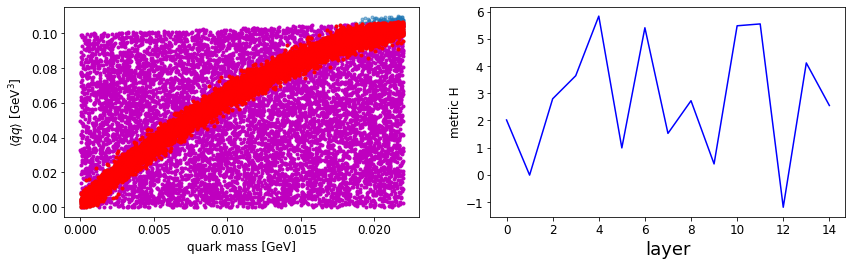

training epoch: 0,   loss: 0.6106791496276855
lambda: 0.3383350074291229,   AdS radius: 1.0615237951278687[1/GeV]
[ 2.0124626  -0.01450864  2.7918518   3.6398106   5.832037    0.98559856
  5.4038544   1.5196042   2.7203536   0.39625233  5.476711    5.544836
 -1.1967394   4.110373    2.5451615 ]


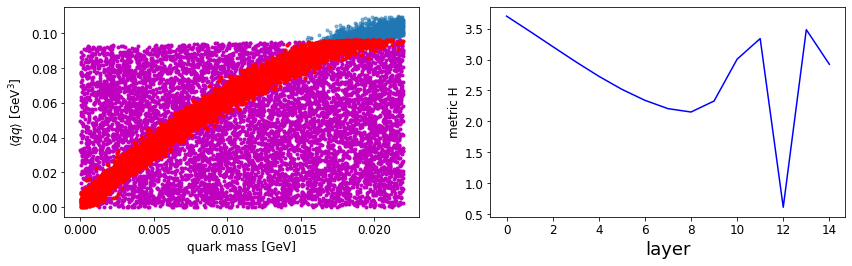

training epoch: 100,   loss: 0.24939313530921936
lambda: -1.5841387510299683,   AdS radius: 1.047944188117981[1/GeV]
[3.701179  3.457796  3.2099738 2.964174  2.729954  2.5187356 2.3409777
 2.206631  2.1519363 2.329739  3.0059445 3.3381248 0.6137018 3.4826686
 2.9227595]


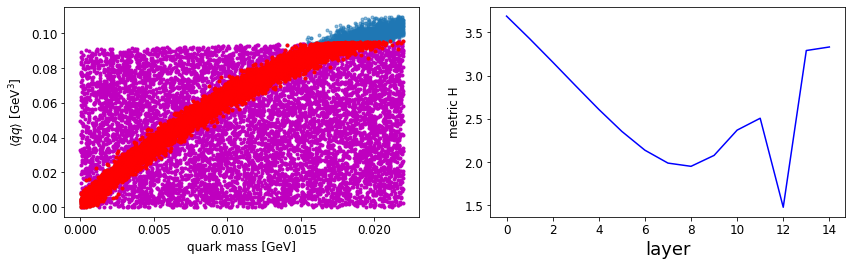

training epoch: 200,   loss: 0.24781617522239685
lambda: -3.2456696033477783,   AdS radius: 1.1237412691116333[1/GeV]
[3.685927  3.4255242 3.1553645 2.8804374 2.6090465 2.354539  2.1374598
 1.9884698 1.9511545 2.077245  2.3691714 2.5064104 1.4785409 3.2885523
 3.3293986]


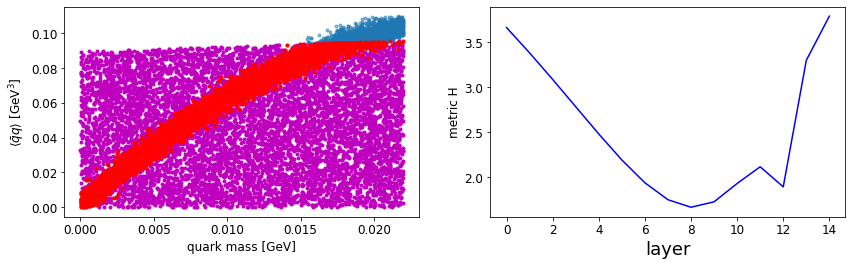

training epoch: 300,   loss: 0.24677404761314392
lambda: -4.778775691986084,   AdS radius: 1.2097997665405273[1/GeV]
[3.6627176 3.3813643 3.0869749 2.7843955 2.482125  2.1939151 1.9407508
 1.7528061 1.669314  1.7296042 1.9329256 2.118204  1.8955235 3.29909
 3.789507 ]


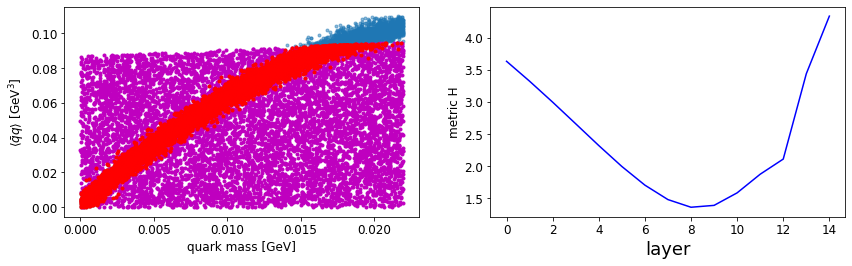

training epoch: 400,   loss: 0.24596348404884338
lambda: -6.181425094604492,   AdS radius: 1.3375084400177002[1/GeV]
[3.6306233 3.3203816 2.9942539 2.6574364 2.3189902 1.9934324 1.702673
 1.4777312 1.3586584 1.3876615 1.5825925 1.8726735 2.1085818 3.436798
 4.333745 ]


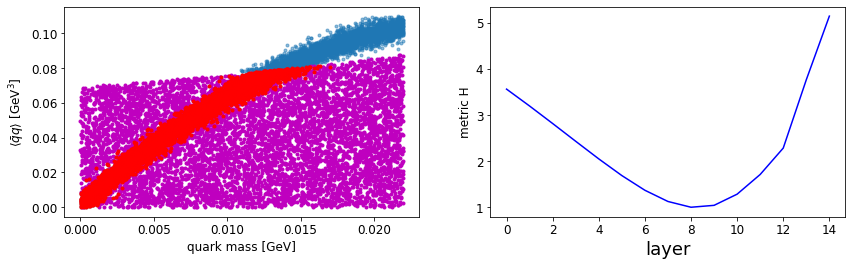

training epoch: 500,   loss: 0.2418222874403
lambda: -7.314929962158203,   AdS radius: 1.7086658477783203[1/GeV]
[3.5589046 3.1929586 2.814293  2.4295223 2.0488763 1.6879532 1.3698556
 1.127147  1.0023683 1.043435  1.2854738 1.7117013 2.2828152 3.7616935
 5.138907 ]


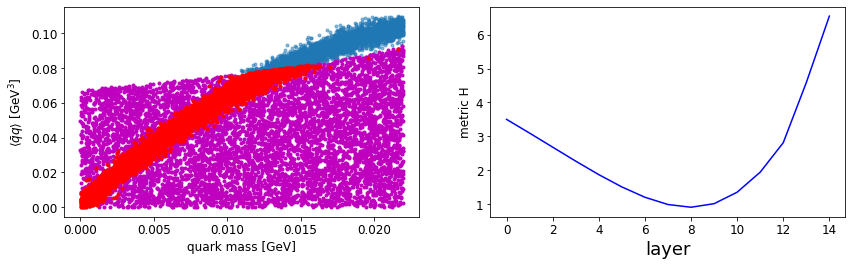

training epoch: 600,   loss: 0.2387361079454422
lambda: -7.227528095245361,   AdS radius: 1.7262598276138306[1/GeV]
[3.5012696  3.095275   2.6804872  2.2672768  1.869732   1.5063112
 1.2011958  0.98675746 0.90602577 1.0110716  1.3501606  1.9415059
 2.8111997  4.58749    6.5502534 ]


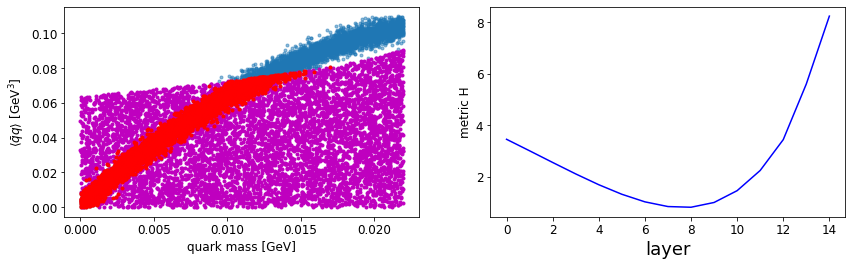

training epoch: 700,   loss: 0.23538604378700256
lambda: -7.075366973876953,   AdS radius: 1.7390154600143433[1/GeV]
[3.4519002 3.0055108 2.553549  2.109393  1.6909399 1.3208578 1.0271065
 0.8445169 0.8176394 1.0024074 1.46018   2.2432497 3.4379857 5.5955663
 8.22694  ]


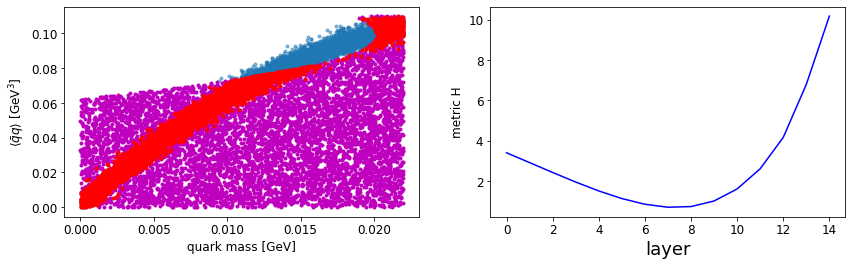

training epoch: 800,   loss: 0.23013150691986084
lambda: -6.85008430480957,   AdS radius: 1.742098093032837[1/GeV]
[ 3.3943105   2.9070015   2.4169552   1.9407283   1.500106    1.122159
  0.8393196   0.6904842   0.72391707  1.0012165   1.5980121   2.6015017
  4.1585536   6.786419   10.179876  ]


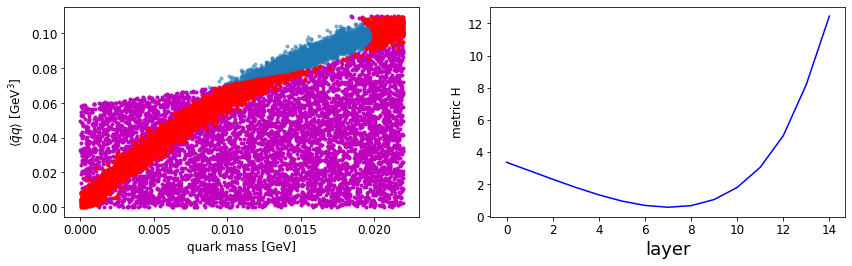

training epoch: 900,   loss: 0.22372967004776
lambda: -6.5104079246521,   AdS radius: 1.7443276643753052[1/GeV]
[ 3.3458457   2.818218    2.2900512   1.7811146   1.3172678   0.9303113
  0.65775967  0.543664    0.6418405   1.0220475   1.7769446   3.0317624
  4.9982862   8.194544   12.456749  ]


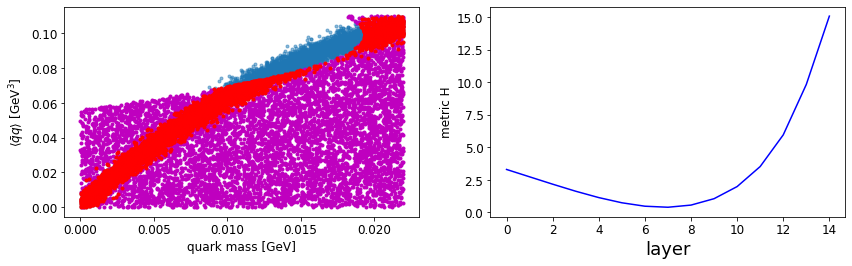

training epoch: 1000,   loss: 0.21725933253765106
lambda: -6.024745464324951,   AdS radius: 1.7379698753356934[1/GeV]
[ 3.29969     2.7338927   2.1684535   1.6263944   1.1379403   0.74013555
  0.47629464  0.39668182  0.5624096   1.0540745   1.9852608   3.5245576
  5.9568563   9.83055    15.081351  ]


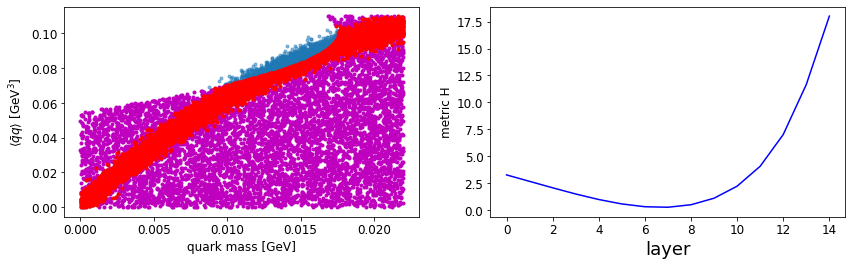

training epoch: 1100,   loss: 0.20962782204151154
lambda: -5.366632461547852,   AdS radius: 1.733330488204956[1/GeV]
[ 3.2574713   2.6577873   2.057508    1.4827894   0.9683852   0.5570525
  0.29867527  0.25082546  0.48347485  1.0905957   2.2107756   4.062251
  7.0128636  11.667576   18.021109  ]


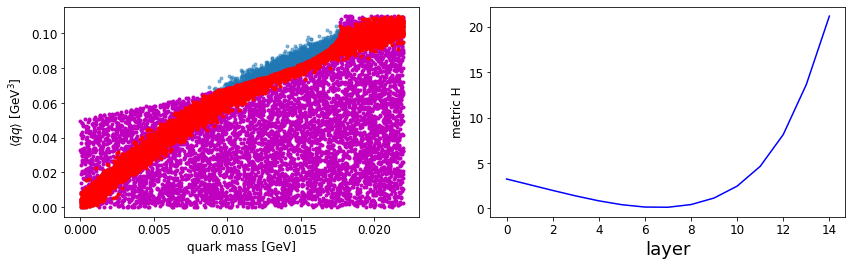

training epoch: 1200,   loss: 0.20158959925174713
lambda: -4.51491641998291,   AdS radius: 1.7386099100112915[1/GeV]
[ 3.229784    2.6024053   1.971457    1.3657961   0.82453835  0.3964695
  0.13873565  0.117152    0.41179267  1.1319265   2.444362    4.6222534
  8.124734   13.635636   21.178062  ]


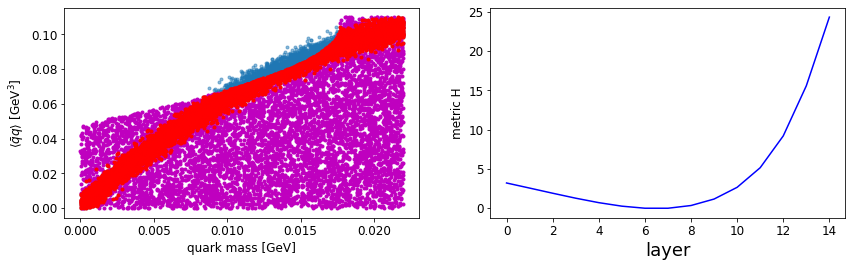

training epoch: 1300,   loss: 0.19549036026000977
lambda: -3.4758143424987793,   AdS radius: 1.756111741065979[1/GeV]
[ 3.21005130e+00  2.56172824e+00  1.90543187e+00  1.27199304e+00
  7.04360604e-01  2.57106096e-01 -5.14347665e-03 -7.81893171e-03
  3.39889795e-01  1.16333652e+00  2.65872097e+00  5.15574121e+00
  9.20722866e+00  1.55901785e+01  2.43451996e+01]


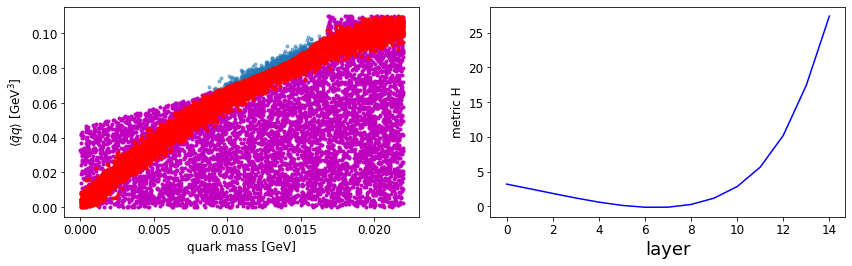

training epoch: 1400,   loss: 0.1892743557691574
lambda: -2.2702865600585938,   AdS radius: 1.8082921504974365[1/GeV]
[ 3.1946826   2.5308204   1.8541102   1.1965376   0.6040343   0.13631113
 -0.13488166 -0.12628089  0.263596    1.1758199   2.835107    5.625444
 10.1898155  17.407932   27.356947  ]


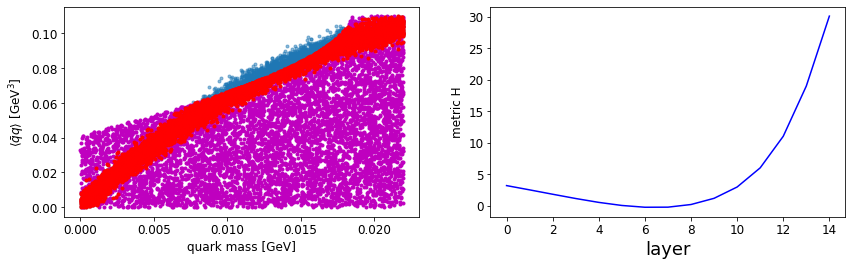

training epoch: 1500,   loss: 0.18335294723510742
lambda: -0.8967561721801758,   AdS radius: 1.9747827053070068[1/GeV]
[ 3.183428    2.5058112   1.8118844   1.1337364   0.5190739   0.03153038
 -0.25110865 -0.23781073  0.1825608   1.1651417   2.9598823   5.998985
 11.007866   18.977757   30.07255   ]


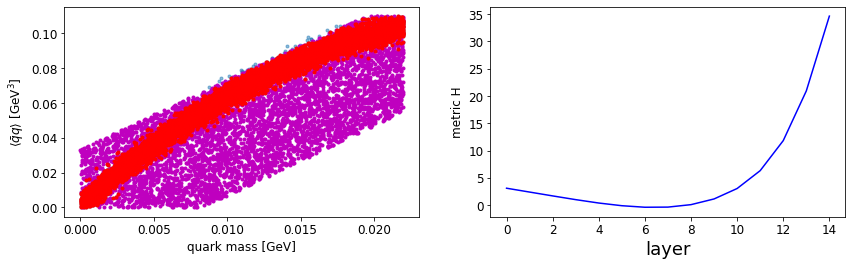

training epoch: 1600,   loss: 0.12443807721138
lambda: 8.106435416266322e-05,   AdS radius: 4.031577110290527[1/GeV]
[ 3.0876884   2.382124    1.6772879   0.9919865   0.3710117  -0.12067845
 -0.4018175  -0.37612882  0.07512461  1.1198518   3.0339837   6.3090534
 11.816279   20.929255   34.65075   ]


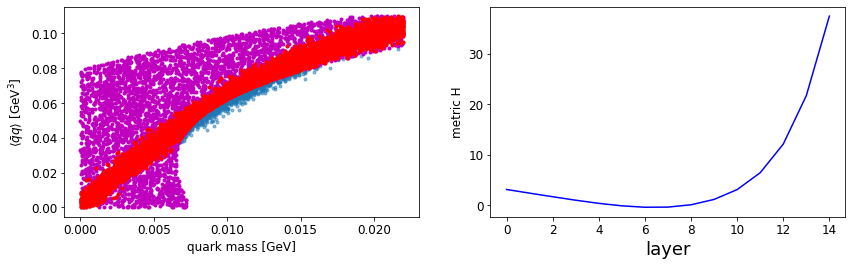

training epoch: 1700,   loss: 0.09323935210704803
lambda: 0.005001564975827932,   AdS radius: 4.120604038238525[1/GeV]
[ 3.0881279   2.3635595   1.6492445   0.9609941   0.33868587 -0.15372215
 -0.43425244 -0.40522736  0.05421108  1.1156446   3.0628629   6.407369
 12.080161   21.692547   37.46499   ]


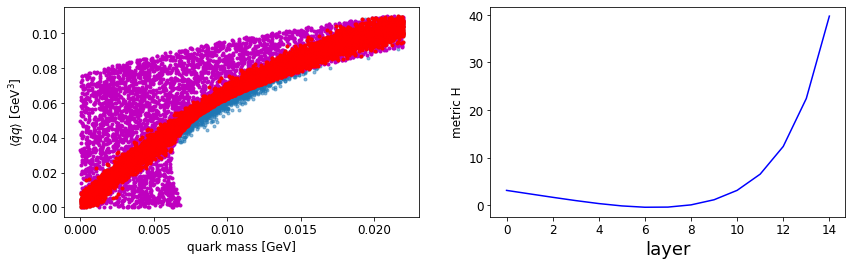

training epoch: 1800,   loss: 0.087638720870018
lambda: 0.005561721511185169,   AdS radius: 4.087210655212402[1/GeV]
[ 3.0964785   2.365753    1.642224    0.9494288   0.32518756 -0.16825905
 -0.44859457 -0.41687557  0.04973574  1.1262091   3.1035855   6.5116553
 12.337605   22.415504   39.74073   ]


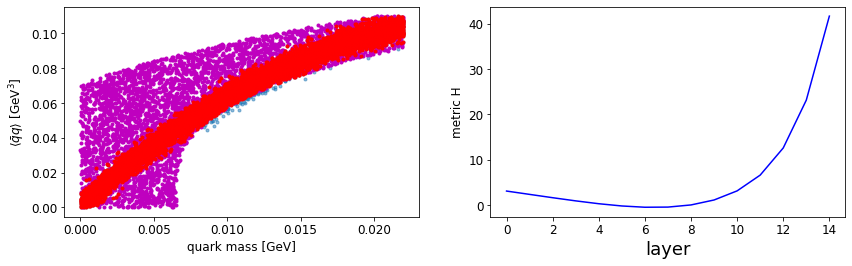

training epoch: 1900,   loss: 0.08609277009963989
lambda: 0.004716729279607534,   AdS radius: 4.077297210693359[1/GeV]
[ 3.1036422   2.3706038   1.6397507   0.9415145   0.31463227 -0.1801491
 -0.46051285 -0.42632398  0.04720725  1.1384271   3.1456602   6.617222
 12.597502   23.136229   41.636936  ]


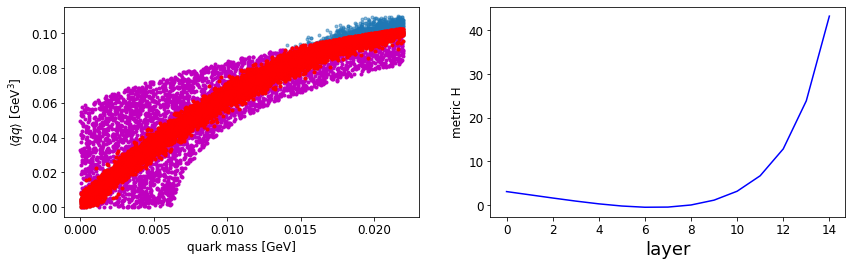

training epoch: 2000,   loss: 0.08472493290901184
lambda: 0.005611842963844538,   AdS radius: 4.040080547332764[1/GeV]
[ 3.1087182   2.374716    1.6385067   0.93483603  0.30488127 -0.19138928
 -0.47183317 -0.43524364  0.04511993  1.1510154   3.1880713   6.7235236
 12.860451   23.848804   43.208786  ]


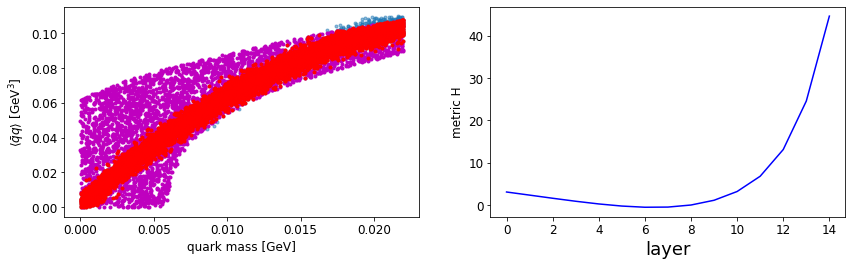

training epoch: 2100,   loss: 0.08385586738586426
lambda: 0.00491375382989645,   AdS radius: 4.068824768066406[1/GeV]
[ 3.1094685e+00  2.3747969e+00  1.6343273e+00  9.2535889e-01
  2.9188159e-01 -2.0612161e-01 -4.8670277e-01 -4.4766134e-01
  3.9733633e-02  1.1608050e+00  3.2289217e+00  6.8314648e+00
  1.3134190e+01  2.4575258e+01  4.4619083e+01]


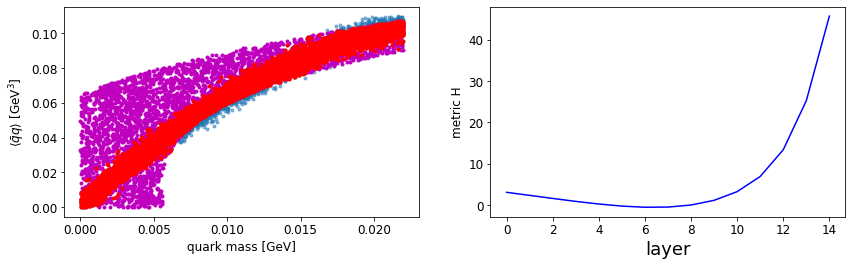

training epoch: 2200,   loss: 0.08457189798355103
lambda: 0.0056017665192484856,   AdS radius: 4.050122261047363[1/GeV]
[ 3.1090655e+00  2.3739338e+00  1.6302760e+00  9.1661751e-01
  2.7955478e-01 -2.2028770e-01 -5.0104785e-01 -4.5964989e-01
  3.4566667e-02  1.1704371e+00  3.2689922e+00  6.9377222e+00
  1.3404197e+01  2.5260693e+01  4.5734356e+01]


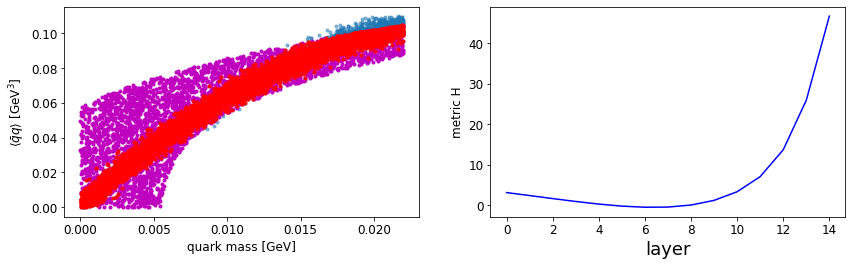

training epoch: 2300,   loss: 0.08320897072553635
lambda: 0.005662210285663605,   AdS radius: 4.022610187530518[1/GeV]
[ 3.1108780e+00  2.3752811e+00  1.6290152e+00  9.1119760e-01
  2.7054766e-01 -2.3123756e-01 -5.1219928e-01 -4.6844557e-01
  3.2583997e-02  1.1832703e+00  3.3124208e+00  7.0482345e+00
  1.3680064e+01  2.5924170e+01  4.6687687e+01]


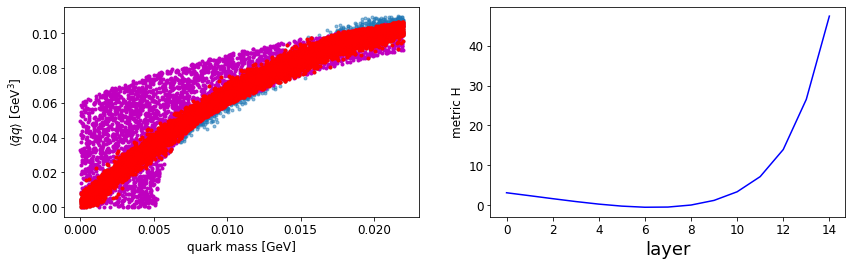

training epoch: 2400,   loss: 0.08296732604503632
lambda: 0.005886675324290991,   AdS radius: 3.999661922454834[1/GeV]
[ 3.1105213e+00  2.3743646e+00  1.6257434e+00  9.0400881e-01
  2.5965083e-01 -2.4431276e-01 -5.2563101e-01 -4.7961518e-01
  2.8170986e-02  1.1936913e+00  3.3537223e+00  7.1575928e+00
  1.3955383e+01  2.6548555e+01  4.7433075e+01]


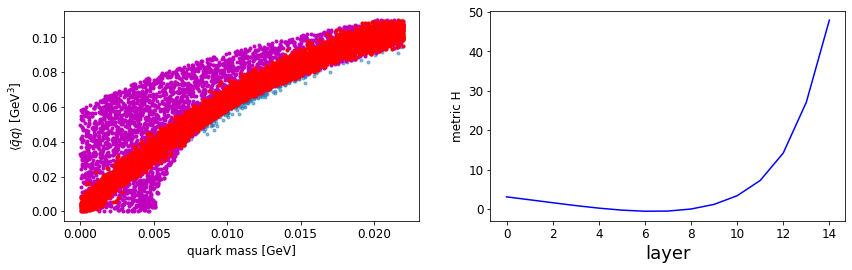

training epoch: 2500,   loss: 0.08335138112306595
lambda: 0.004601345397531986,   AdS radius: 3.985961437225342[1/GeV]
[ 3.1127086e+00  2.3759997e+00  1.6251831e+00  8.9975029e-01
  2.5163445e-01 -2.5474051e-01 -5.3662759e-01 -4.8858792e-01
  2.5633693e-02  1.2055198e+00  3.3956783e+00  7.2662787e+00
  1.4223437e+01  2.7107611e+01  4.7949638e+01]


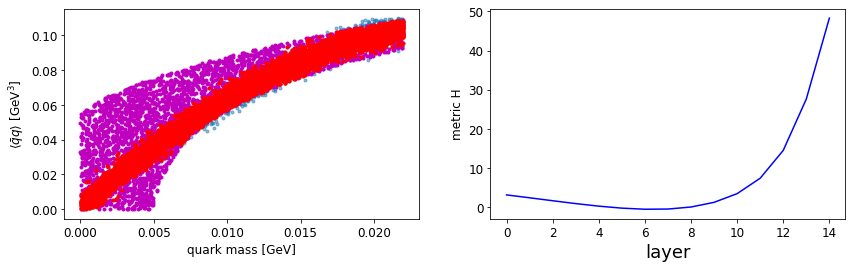

training epoch: 2600,   loss: 0.07951001077890396
lambda: 0.005369367077946663,   AdS radius: 3.958993434906006[1/GeV]
[ 3.1138971e+00  2.3768532e+00  1.6239594e+00  8.9495432e-01
  2.4297903e-01 -2.6606739e-01 -5.4876840e-01 -4.9891493e-01
  2.1527356e-02  1.2155422e+00  3.4355843e+00  7.3725214e+00
  1.4483425e+01  2.7601473e+01  4.8273514e+01]


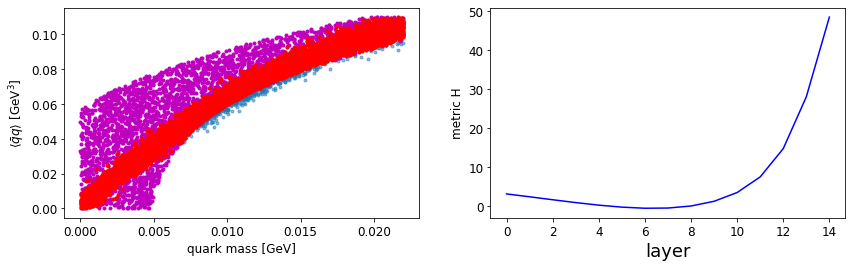

training epoch: 2700,   loss: 0.07911594957113266
lambda: 0.004460989031940699,   AdS radius: 3.9754550457000732[1/GeV]
[ 3.1155584e+00  2.3782146e+00  1.6233418e+00  8.9083099e-01
  2.3489931e-01 -2.7706051e-01 -5.6078589e-01 -5.0926358e-01
  1.7306427e-02  1.2254610e+00  3.4756408e+00  7.4795747e+00
  1.4740326e+01  2.8047699e+01  4.8521500e+01]


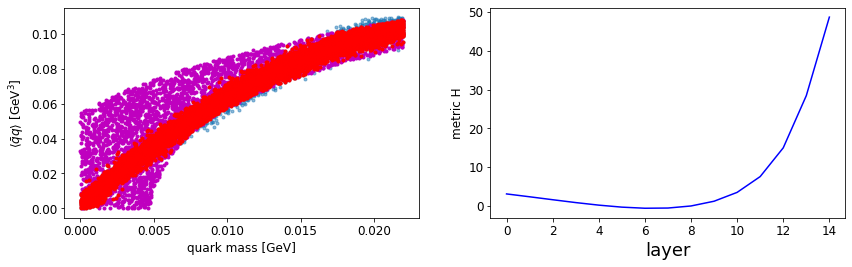

training epoch: 2800,   loss: 0.07986856251955032
lambda: 0.005455414764583111,   AdS radius: 3.950909376144409[1/GeV]
[ 3.1168361e+00  2.3794870e+00  1.6228977e+00  8.8709629e-01
  2.2725768e-01 -2.8774932e-01 -5.7265854e-01 -5.1960146e-01
  1.2982335e-02  1.2351780e+00  3.5154607e+00  7.5861144e+00
  1.4989461e+01  2.8435993e+01  4.8667915e+01]


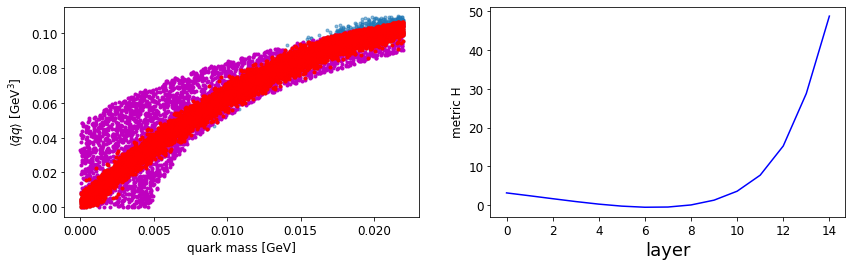

training epoch: 2900,   loss: 0.0804741382598877
lambda: 0.005374266300350428,   AdS radius: 3.9240238666534424[1/GeV]
[ 3.1195560e+00  2.3822470e+00  1.6241553e+00  8.8524228e-01
  2.2153427e-01 -2.9664561e-01 -5.8291477e-01 -5.2847129e-01
  9.9700475e-03  1.2460340e+00  3.5562716e+00  7.6930437e+00
  1.5229851e+01  2.8771055e+01  4.8750599e+01]


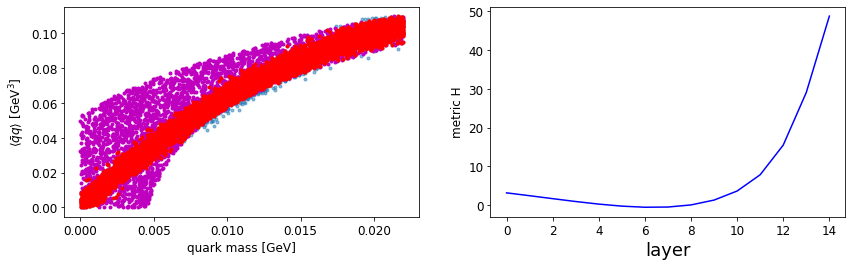

training epoch: 3000,   loss: 0.07789604365825653
lambda: 0.005064100027084351,   AdS radius: 3.9215705394744873[1/GeV]
[ 3.1204033e+00  2.3832412e+00  1.6236836e+00  8.8171601e-01
  2.1409705e-01 -3.0744958e-01 -5.9530222e-01 -5.3965670e-01
  4.5002764e-03  1.2543553e+00  3.5945435e+00  7.7969661e+00
  1.5458056e+01  2.9054981e+01  4.8768185e+01]


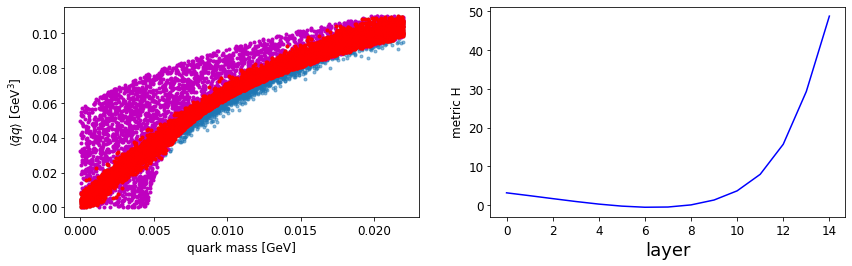

training epoch: 3100,   loss: 0.07897450774908066
lambda: 0.005606761202216148,   AdS radius: 3.8839168548583984[1/GeV]
[ 3.1203792e+00  2.3835049e+00  1.6228038e+00  8.7809193e-01
  2.0676529e-01 -3.1810459e-01 -6.0758358e-01 -5.5077833e-01
 -9.4687025e-04  1.2626663e+00  3.6328411e+00  7.9002891e+00
  1.5676743e+01  2.9305819e+01  4.8802395e+01]


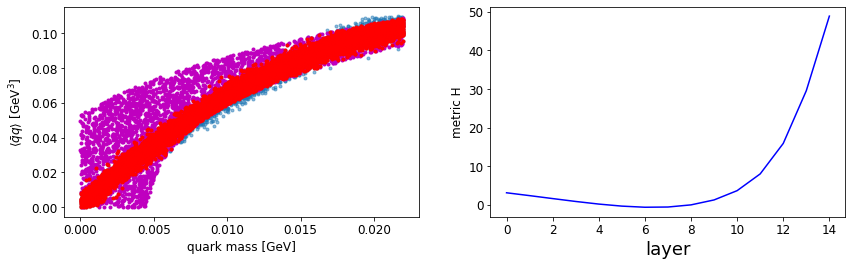

training epoch: 3200,   loss: 0.07772424817085266
lambda: 0.0061244480311870575,   AdS radius: 3.885974168777466[1/GeV]
[ 3.1222847e+00  2.3855624e+00  1.6237242e+00  8.7632048e-01
  2.0126130e-01 -3.2708028e-01 -6.1837357e-01 -5.6053728e-01
 -5.0505069e-03  1.2724622e+00  3.6730824e+00  8.0056515e+00
  1.5889592e+01  2.9528429e+01  4.8820438e+01]


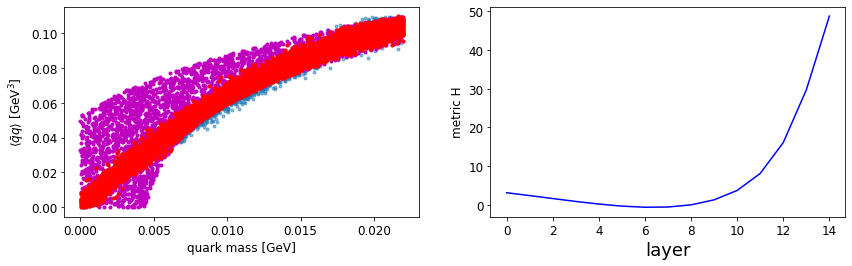

training epoch: 3300,   loss: 0.07916085422039032
lambda: 0.00589775200933218,   AdS radius: 3.8677704334259033[1/GeV]
[ 3.1237488e+00  2.3873396e+00  1.6245335e+00  8.7468177e-01
  1.9608223e-01 -3.3567607e-01 -6.2884301e-01 -5.7010818e-01
 -9.1824206e-03  1.2818687e+00  3.7121668e+00  8.1072559e+00
  1.6086277e+01  2.9713390e+01  4.8800274e+01]


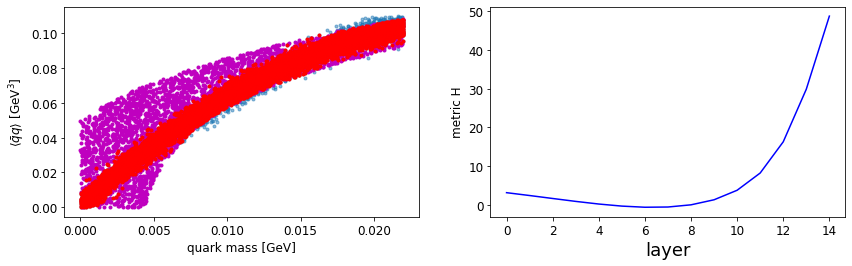

training epoch: 3400,   loss: 0.07760007679462433
lambda: 0.006010999903082848,   AdS radius: 3.876736640930176[1/GeV]
[ 3.1254551e+00  2.3892741e+00  1.6255012e+00  8.7324739e-01
  1.9111972e-01 -3.4415334e-01 -6.3935214e-01 -5.7983392e-01
 -1.3510642e-02  1.2911688e+00  3.7514455e+00  8.2083616e+00
  1.6273638e+01  2.9873352e+01  4.8761387e+01]


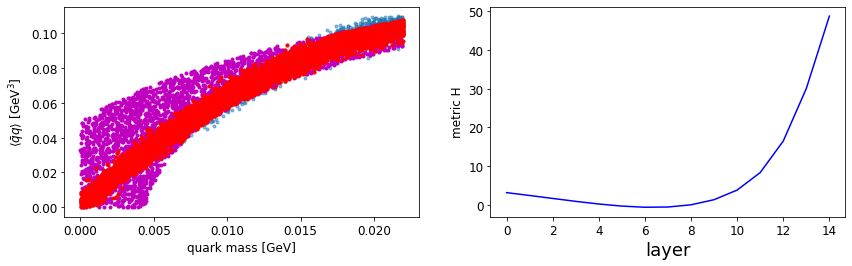

training epoch: 3500,   loss: 0.07782790064811707
lambda: 0.006456722971051931,   AdS radius: 3.840764045715332[1/GeV]
[ 3.1266112e+00  2.3908646e+00  1.6263809e+00  8.7200528e-01
  1.8659565e-01 -3.5206917e-01 -6.4928597e-01 -5.8903086e-01
 -1.7381968e-02  1.3008033e+00  3.7907076e+00  8.3075237e+00
  1.6449396e+01  3.0013205e+01  4.8738033e+01]


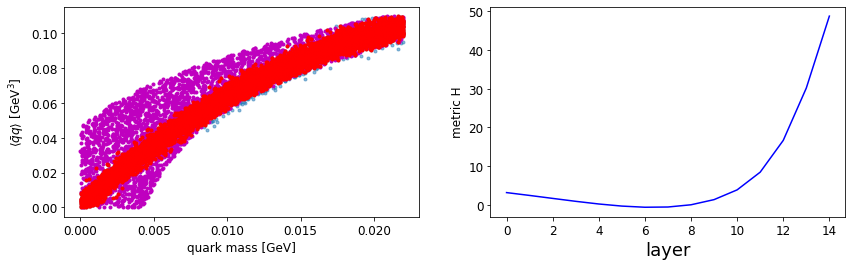

training epoch: 3600,   loss: 0.08368948101997375
lambda: 0.005266775842756033,   AdS radius: 3.8374898433685303[1/GeV]
[ 3.1282823e+00  2.3928497e+00  1.6276506e+00  8.7118876e-01
  1.8251738e-01 -3.5959825e-01 -6.5894282e-01 -5.9798193e-01
 -2.0876907e-02  1.3112468e+00  3.8317108e+00  8.4088783e+00
  1.6622437e+01  3.0150793e+01  4.8748524e+01]


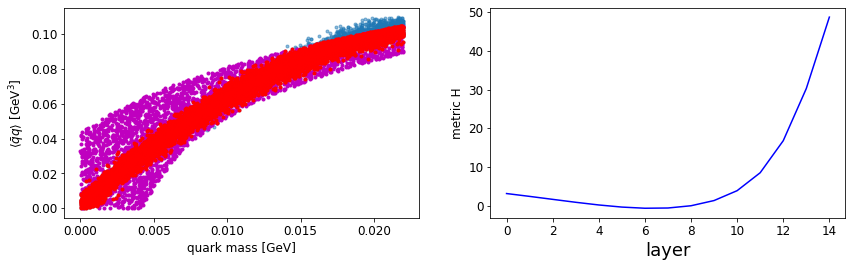

training epoch: 3700,   loss: 0.07750224322080612
lambda: 0.006289272103458643,   AdS radius: 3.844261407852173[1/GeV]
[ 3.1298180e+00  2.3945727e+00  1.6286759e+00  8.7023842e-01
  1.7841001e-01 -3.6713085e-01 -6.6868216e-01 -6.0713607e-01
 -2.4740003e-02  1.3210706e+00  3.8715403e+00  8.5063400e+00
  1.6781143e+01  3.0263206e+01  4.8715755e+01]


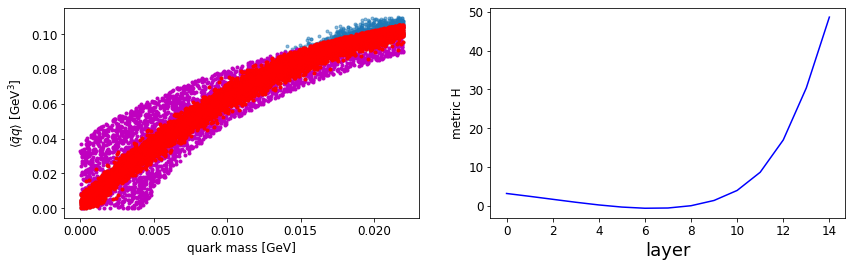

training epoch: 3800,   loss: 0.07805652171373367
lambda: 0.00531970988959074,   AdS radius: 3.851715564727783[1/GeV]
[ 3.1324086e+00  2.3974860e+00  1.6308724e+00  8.7047559e-01
  1.7550260e-01 -3.7352917e-01 -6.7742401e-01 -6.1543298e-01
 -2.7809519e-02  1.3317527e+00  3.9122491e+00  8.6028852e+00
  1.6929638e+01  3.0350914e+01  4.8622234e+01]


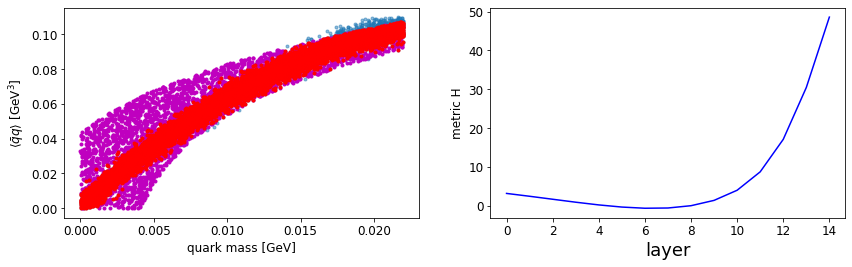

training epoch: 3900,   loss: 0.07705775648355484
lambda: 0.005829008296132088,   AdS radius: 3.85054874420166[1/GeV]
[ 3.1319301e+00  2.3973415e+00  1.6301677e+00  8.6799276e-01
  1.7009225e-01 -3.8226911e-01 -6.8844533e-01 -6.2603724e-01
 -3.3266906e-02  1.3398664e+00  3.9497981e+00  8.6936817e+00
  1.7065414e+01  3.0431274e+01  4.8576397e+01]


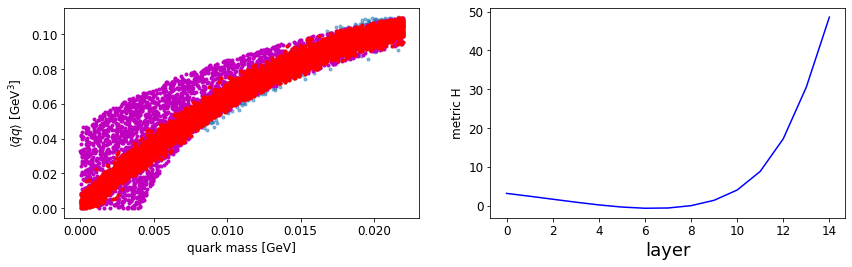

training epoch: 4000,   loss: 0.07757051289081573
lambda: 0.005424098111689091,   AdS radius: 3.8499979972839355[1/GeV]
[ 3.1323578e+00  2.3981621e+00  1.6305032e+00  8.6664367e-01
  1.6588050e-01 -3.8980275e-01 -6.9830781e-01 -6.3548058e-01
 -3.7420880e-02  1.3496950e+00  3.9897761e+00  8.7866030e+00
  1.7199398e+01  3.0514263e+01  4.8570797e+01]


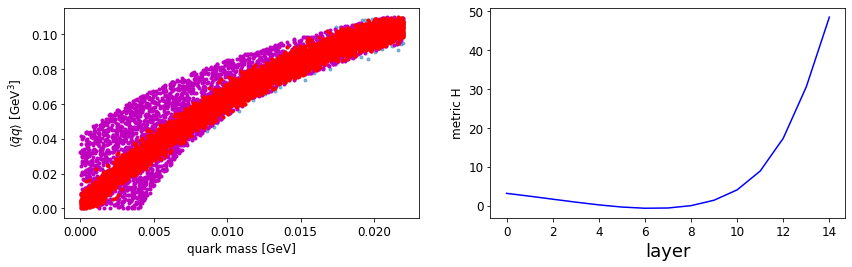

training epoch: 4100,   loss: 0.08043092489242554
lambda: 0.0048293499276041985,   AdS radius: 3.8218846321105957[1/GeV]
[ 3.1339347e+00  2.3999960e+00  1.6319654e+00  8.6665130e-01
  1.6329221e-01 -3.9548939e-01 -7.0620823e-01 -6.4298761e-01
 -3.9817344e-02  1.3608378e+00  4.0298529e+00  8.8759489e+00
  1.7322817e+01  3.0589783e+01  4.8550022e+01]


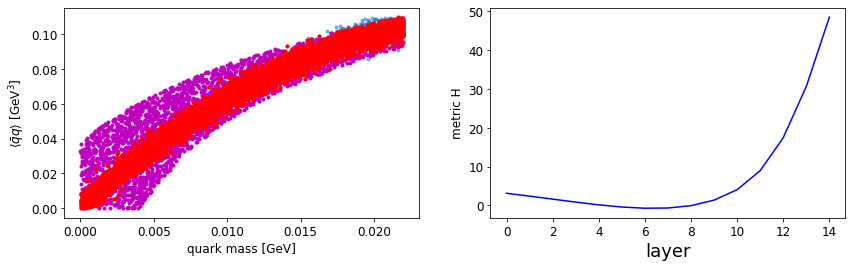

training epoch: 4200,   loss: 0.07670875638723373
lambda: 0.00460320059210062,   AdS radius: 3.840643882751465[1/GeV]
[ 3.1355674e+00  2.4017627e+00  1.6332136e+00  8.6636341e-01
  1.6034010e-01 -4.0164268e-01 -7.1471471e-01 -6.5120274e-01
 -4.2875756e-02  1.3716009e+00  4.0700083e+00  8.9642210e+00
  1.7440023e+01  3.0654312e+01  4.8513752e+01]


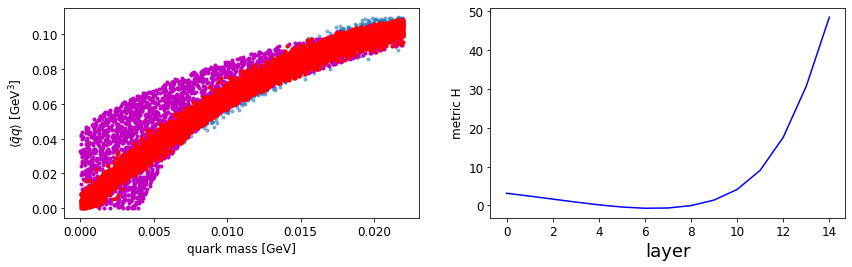

training epoch: 4300,   loss: 0.07729391753673553
lambda: 0.005912018474191427,   AdS radius: 3.833751916885376[1/GeV]
[ 3.1342351e+00  2.4007220e+00  1.6317527e+00  8.6350060e-01
  1.5498999e-01 -4.1004339e-01 -7.2539836e-01 -6.6161358e-01
 -4.8176553e-02  1.3799772e+00  4.1072197e+00  9.0470161e+00
  1.7547274e+01  3.0711811e+01  4.8485725e+01]


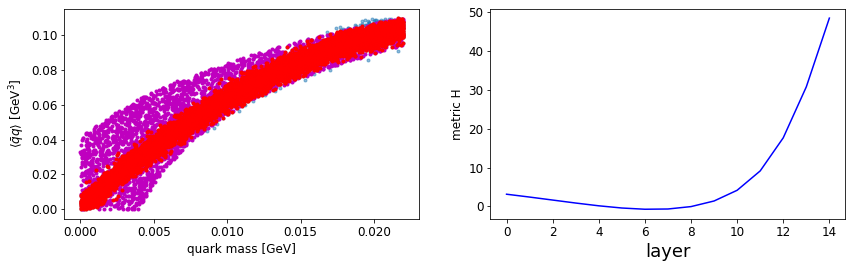

training epoch: 4400,   loss: 0.07726722955703735
lambda: 0.005315045826137066,   AdS radius: 3.8182122707366943[1/GeV]
[ 3.1357598   2.4023795   1.6330426   0.86348414  0.15258878 -0.4154265
 -0.7330536  -0.6689789  -0.05034276  1.3917364   4.1479907   9.132153
 17.65383    30.772282   48.469757  ]


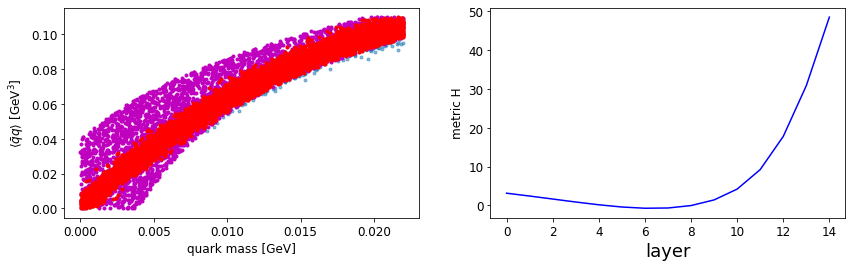

training epoch: 4500,   loss: 0.07780961692333221
lambda: 0.004236933775246143,   AdS radius: 3.838331937789917[1/GeV]
[ 3.136488    2.4032907   1.6335089   0.8626585   0.14943305 -0.4215151
 -0.7413958  -0.67700624 -0.05305802  1.4032351   4.1887484   9.216521
 17.758772   30.843094   48.508724  ]


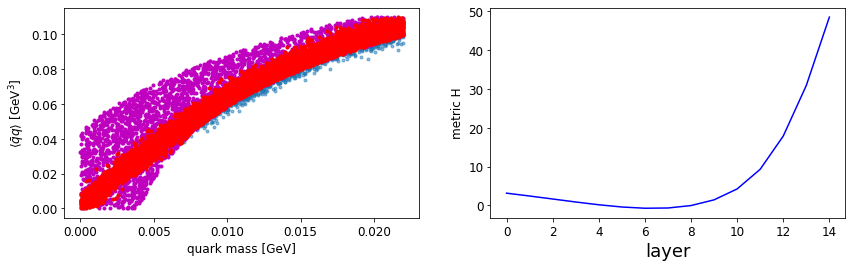

training epoch: 4600,   loss: 0.07844455540180206
lambda: 0.004908339586108923,   AdS radius: 3.81166410446167[1/GeV]
[ 3.1356857   2.4025638   1.6324918   0.86053103  0.1452231  -0.4284146
 -0.750405   -0.6856821  -0.05656485  1.4134895   4.2269835   9.294928
 17.854124   30.90609    48.524097  ]


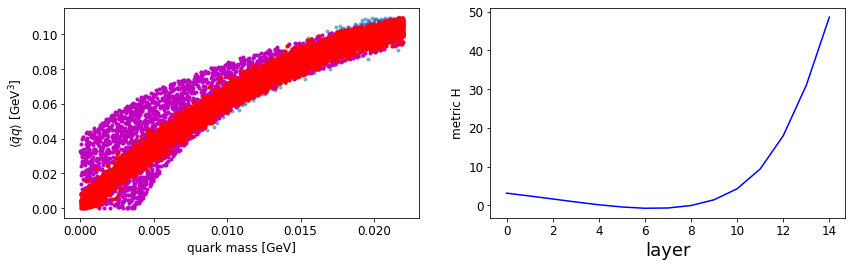

training epoch: 4700,   loss: 0.07693426311016083
lambda: 0.005515750963240862,   AdS radius: 3.810849666595459[1/GeV]
[ 3.1363916   2.4033623   1.632911    0.8598069   0.1424078  -0.43393493
 -0.758062   -0.6930002  -0.05858815  1.4256014   4.2675033   9.375032
 17.949553   30.97178    48.552094  ]


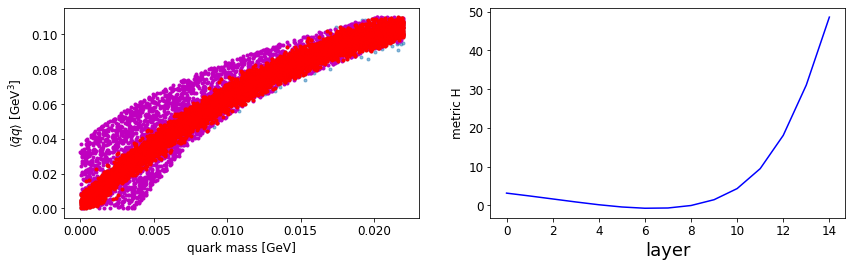

training epoch: 4800,   loss: 0.0770646408200264
lambda: 0.004428328480571508,   AdS radius: 3.8117618560791016[1/GeV]
[ 3.1375902   2.4046073   1.63376     0.85956603  0.1401932  -0.43871632
 -0.7648984  -0.699518   -0.05992188  1.4380692   4.307359    9.451757
 18.039394   31.03266    48.555824  ]


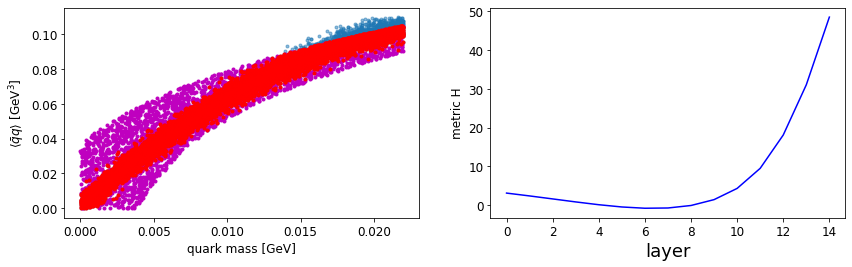

training epoch: 4900,   loss: 0.0760420486330986
lambda: 0.006117776967585087,   AdS radius: 3.8074541091918945[1/GeV]
[ 3.1375675   2.404519    1.6332712   0.858026    0.13674821 -0.4446583
 -0.7728556  -0.7071589  -0.06239142  1.4493771   4.3455806   9.524967
 18.12313    31.084925   48.544712  ]


In [43]:
negx, negy, posx, posy, Hs = plot_phase_and_metric(threshold=0.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test)
total_epoch=5000
show_epoch_each=100

for epoch in range(total_epoch):
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, pi, ans = Variable(b_phi), Variable(b_pi), Variable(b_ans)
        loss = Test.loss(phi=phi, pi=pi, answer=ans)
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(threshold=0.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test)
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
        print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layer)]))

In [37]:
print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layer)]))

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [0]:
%%bash
mkdir trained_models

mkdir: trained_models: File exists


Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [0]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [0]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [0]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

array([[ 3.85264516]], dtype=float32)

In [0]:
model.lamb.weight.data.numpy() # lambda

array([[ 0.00545012]], dtype=float32)

In [0]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)

[[ 3.13351607]]
[[ 2.39271212]]
[[ 1.60696924]]
[[ 0.8100372]]
[[ 0.06195514]]
[[-0.5439406]]
[[-0.87814671]]
[[-0.77317631]]
[[-0.00735563]]
[[ 1.74285817]]
[[ 4.97534227]]
[[ 10.37840176]]
[[ 18.70586967]]
[[ 30.80181313]]
[[ 46.99329758]]
